In [1]:
!pip -q install inltk

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import re
import os
import sentencepiece as spm
import pickle
import pathlib
from fastai.text import *
torch.cuda.set_device(0)

working_path = '/kaggle/working'
input_data_path = '/kaggle/input'

data_paths = {}
for dirname, _, filenames in os.walk(input_data_path):
    for filename in filenames:
        data_paths[filename] = os.path.join(dirname, filename)
        print(os.path.join(dirname, filename))

/kaggle/input/telugu-wikipedia-data/telugu_wiki_links.csv
/kaggle/input/telugu-wikipedia-data/telugu_wikipedia_dataset.parquet
/kaggle/input/telugu-sentencepiece-tokenizer/telugu_tok.vocab
/kaggle/input/telugu-sentencepiece-tokenizer/telugu_tok.model
/kaggle/input/telugu-sentencepiece-tokenizer/__results__.html
/kaggle/input/telugu-sentencepiece-tokenizer/TeluguWikiSentences.txt
/kaggle/input/telugu-sentencepiece-tokenizer/__notebook__.ipynb
/kaggle/input/telugu-sentencepiece-tokenizer/custom.css
/kaggle/input/telugu-sentencepiece-tokenizer/__output__.json


In [3]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.3.0')

In [4]:
tel_df = pd.read_parquet(data_paths['telugu_wikipedia_dataset.parquet'])
tel_df.shape, tel_df.columns

((99052, 2), Index(['title', 'text'], dtype='object'))

In [5]:
texts = (tel_df['title'] + ' ' + tel_df['text']).tolist()
texts = [t for t in tel_df['text'] if len(t.strip())>1]
print(len(texts))

94435


In [6]:
df = pd.DataFrame(texts, columns = ['text'])

In [7]:
del tel_df, texts
gc.collect()

117

In [8]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2)
train_df.shape, test_df.shape

((75548, 1), (18887, 1))

In [9]:
sp = spm.SentencePieceProcessor()
sp.Load(data_paths['telugu_tok.model'])
itos = [sp.IdToPiece(int(i)) for i in range(25000)] # 25,000 is the vocab_size selected in sm tokenizer
telugu_vocab = Vocab(itos)

In [10]:
from telugu_tokenizer_class_fastai import TeluguTokenizer
tokenizer = Tokenizer(tok_func=TeluguTokenizer, lang='te')
tokenizer.special_cases

1.0.57


['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [11]:
data_lm = TextLMDataBunch.from_df(working_path, train_df=train_df, valid_df=test_df,
                                  text_cols=["text"], bs=96,
                                  tokenizer=tokenizer, vocab=telugu_vocab) # default bs=64
data_lm.save('telugu_lm.data')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [12]:
data_lm.show_batch()

idx,text
0,"35 ▁జనాభాతో ▁5 01 ▁హెక్టార్లలో ▁విస్తరించి ▁ఉంది . ▁గ్రామంలో ▁మగవారి ▁సంఖ్య ▁4 63 , ▁ఆడవారి ▁సంఖ్య ▁4 72 . ▁షెడ్యూల్డ్ ▁కులాల ▁సంఖ్య ▁89 ▁కాగా ▁షెడ్యూల్డ్ ▁తెగల ▁సంఖ్య ▁84 . ▁గ్రామం ▁యొక్క ▁జనగణన ▁లొకేషన్ ▁కోడ్ ▁57 38 46 [2]. పిన్ ▁కోడ్ : ▁50 23 06 . ▁గ్రామంలో ▁ప్రభుత్వ ▁ప్రాథమిక ▁పాఠశాల ▁ఒకటి ▁ఉంది . సమీప ▁బాలబడి , ▁ప్రాథమిక ▁పాఠశాల ▁తో గుర్ ▁ పల్లిలోను , ▁ప్రాథమికోన్నత ▁పాఠశాల ▁పెద్ద ాపూర్ ▁( స దా శివ"
1,"నుండి , ▁వరల్డ్ ▁ఛ ె స్ ▁ఫెడరేషన్ ▁మరియూ ▁ఇంటర్నేషనల్ ▁కర స్ పా ండె న్స్ ▁ఛ ె స్ ▁ఫెడరేషన్ , ▁అను ▁రెండు ▁అంతర్జాతీయ ▁సంస్థలు ▁చదరంగ ం ▁ఆటల ▁పోటీ లను ▁నిర్వహిస్తున్న ాయి . ▁కంప్యూటర్ ▁ శాస్త్రజ్ఞుల ▁ఒక ▁లక్ష్యం , ▁కంప్యూటర్ ▁చదరంగ ాన్ని ▁సృష్టించడం , ▁అంటే ▁చదరంగ ం ▁ఆడే ▁కంప్యూటర్ ▁ని ▁సృష్టించడం . ▁ఈ ▁రోజున ▁కంప్యూటర్ ▁చదరంగ ▁ సామర్ధ్య త ▁ప్రభావం ▁నేటి ▁ఆట ▁మీద ▁ఎంతో ▁ఉంది . ▁1997 ▁లో ▁అప్పటి ▁ప్రపంచ ▁ఛాంపియన్ ▁అయిన"
2,"చే శాయి , ▁రాజస్థాన్ ▁పై ▁తన ▁నియంత్రణ ▁కోల్పోయిన ా ▁సిం ధి యా ▁బ్రిటీష్ ▁సైన్యానికి ▁భయపడి ▁తటస్థ ంగా ▁ఉండి పోయాడు . ▁బ్రిటీష్ ▁వారు ▁చాలా ▁వేగంగా ▁విజయాలు ▁అందుకున్నారు . ▁ఫలితంగా ▁మరాఠా ▁సామ్రాజ్యం ▁ముక్క లై , ▁మరాఠా లు ▁స్వాతంత్ర్యం ▁కోల్పోయారు . ▁ఖ డ్ కి , ▁కో రె గావ్ ▁యుద్ధ ాల్లో ▁పీ ష్ వా ▁ఓడిపోయాడు . ▁పీ ష్ వా ▁బందీ ▁కాకుండా ▁అడ్డ ుకునేందుకు ▁పీ ష్ వా ▁సైన్యాలు ▁అనేక ▁చిన్న ా ▁ చిత కా ▁పోరాటాలు"
3,"▁లోయ లు ▁ఉన్నాయి ▁మరియు ▁యా ర్ల ంగ్ ▁త్సాంగ్ పో ▁నది ▁( బ్రహ్మ పుత్ర ▁యొక్క ▁పై ▁కాలువ ) ▁మరియు ▁దాని ▁ప్రధాన ▁ఉప నది ▁అయిన , ▁నయం గ్ ▁నది , ▁సల్ వీ న్ , ▁ యాంగ్ ట్ జే , ▁మె కా ంగ్ , ▁మరియు ▁ఎల్ లో ▁నది ▁ఉన్నాయి . ▁ఈ ▁నది లోని ▁గుర్రపు ▁లా డం ▁వంపు ▁వలన ▁ఏర్పడిన ▁యా ర్ల ంగ్ ▁త్సాంగ్ పో ▁కాన్ యాన్ ▁ప్రపంచములో ▁అత్యంత ▁లోతైన ▁మరియు ▁అతి ▁పొడవైన ▁పెను"
4,", ▁అతను ▁మెకానికల్ ▁ఇంజనీరింగ్ ▁అభ్యసించ టానికి ▁కేంబ్రిడ్జ్ ▁విశ్వవిద్యాలయం ▁య ెుక్క ▁కై స్ ▁కళాశాల కు ▁హాజరైన ారు . ▁మెకానికల్ ▁ఇంజనీరింగ్ ▁పొందిన ▁తరువాత , ▁మ్యా థ మె టిక్స్ ▁ట్రి పో స్ ▁ను ▁పూర్తి ▁చేయడానికి ▁పాల్ ▁డి రాక్ ▁వద్ద ▁అభ్యసించారు . ▁ఈ ▁మధ్యలో , ▁అతను ▁కా వె ండి ష్ ▁లే బ రే టరీ లో <unk> ▁r . <unk> ▁h . ▁ఫౌ లర్ ▁వద్ద ▁సిద్ధాంత పరమైన ▁భౌతికశాస్త్ర ంలో ▁డాక్టరేట్ ▁కొరకు ▁పనిచేస్తూ ▁ఇక్కడ ▁పనిచేశారు ."


In [13]:
len(data_lm.vocab.itos)

25000

In [14]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.25)
learn = learn.to_fp16(clip=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


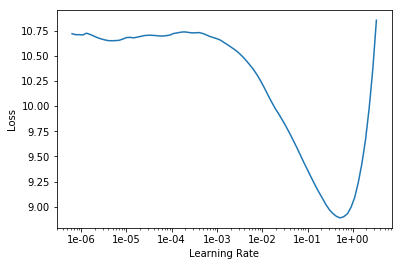

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
learn.save('first', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time


In [17]:
learn.load('first', with_opt=True);

In [18]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))
learn.save('second', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time
0,3.615405,3.824482,0.408811,30:19
1,3.568444,3.696573,0.421402,30:17
2,3.526893,3.425028,0.447008,30:16
3,3.232996,3.125835,0.481430,30:17


In [19]:
learn.load('second', with_opt=True);

In [20]:
# learn.lr_find()
# learn.recorder.plot()

In [21]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))
learn.save('third', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time
0,3.022662,2.994272,0.501283,30:18
1,2.931357,2.975538,0.504437,30:19
2,2.998266,2.924863,0.512323,30:17
3,3.053375,2.889812,0.518073,30:16


In [22]:
learn.load('third', with_opt=True);

In [23]:
learn.fit_one_cycle(5, 1e-4, moms=(0.8,0.7))
learn.save('fourth', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time
0,2.748081,2.876139,0.520277,30:21
1,2.869988,2.873042,0.520904,30:22
2,2.845336,2.867723,0.521872,30:18
3,2.546134,2.865256,0.522314,30:15


In [24]:
learn.load('fourth', with_opt=True);

In [25]:
TEXT = "ఇది మండల కేంద్రమైన రంపచోడవరం నుండి"
N_WORDS = 20
N_SENTENCES = 2

In [26]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.9) for _ in range(N_SENTENCES)))

ఇది మండల కేంద్రమైన రంపచోడవరం నుండి ▁15 ▁కి . ▁మీ . ▁దూరం ▁లోను , ▁సమీప ▁పట్టణమైన ▁అనకాపల్లి ▁నుండి ▁83 ▁కి . ▁మీ . ▁దూరంలోనూ ▁ఉంది .
ఇది మండల కేంద్రమైన రంపచోడవరం నుండి ▁15 ▁కి . ▁మీ . ▁దూరం ▁లోను , ▁సమీప ▁పట్టణమైన ▁జైపూరు ▁( ఒరిస్సా ) ▁నుండి ▁71 ▁కి . ▁మీ .


### Extract embeddings

In [27]:
defaults.device = torch.device('cpu')
learn.model.eval()
learn.export()

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SequentialRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type AWD_LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda

In [28]:
# Generating embedding vectors for visualization

In [29]:
telugu_lm_path = os.path.join(working_path)

In [30]:
!rm -rf models\

In [31]:
!ls

__notebook__.ipynb  export.pkl	models	telugu_lm.data


In [32]:
learn = load_learner(working_path)

In [33]:
encoder = get_model(learn.model)[0]
encoder.state_dict()['encoder.weight'].shape

torch.Size([25000, 400])

In [34]:
embeddings = encoder.state_dict()['encoder.weight']
embeddings = np.array(embeddings)
embeddings[0].shape

(400,)

In [35]:
df1 = pd.DataFrame(embeddings)
df1.shape

(25000, 400)

In [36]:
df1.index = itos

In [37]:
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
<unk>,-0.096375,-0.458252,-0.244873,0.142456,0.172241,-0.785156,-0.202026,-0.949707,0.199829,-0.309082,...,0.108093,-0.320557,-0.125488,-0.196777,0.005756,-0.298340,-0.049011,-0.298828,0.200439,0.071777
<s>,-0.022461,-0.063843,0.025513,0.083801,-0.040863,-0.114441,-0.092285,-0.266846,0.117798,0.141479,...,0.026291,-0.043976,-0.047058,0.018341,0.059479,-0.570801,-0.289795,-0.328125,0.132080,0.049774
</s>,-0.022461,-0.063843,0.025513,0.083801,-0.040863,-0.114441,-0.092285,-0.266846,0.117798,0.141479,...,0.026291,-0.043976,-0.047058,0.018341,0.059479,-0.570801,-0.289795,-0.328125,0.132080,0.049774
.,0.185059,-0.663086,0.093018,0.610840,-0.306396,-0.335693,-0.122498,-0.449951,0.717773,-0.002869,...,-0.033752,0.466064,-0.188721,-0.135376,0.080078,-0.156860,-0.597656,-0.386963,0.131470,-0.339355
",",0.149170,-1.070312,0.212036,0.396729,-0.194580,-0.153809,0.052460,-0.410156,-0.156860,0.151733,...,0.005299,0.448730,-0.045624,-0.130615,0.116028,-0.520508,-0.259766,-0.278320,0.066223,0.343994


In [38]:
df1.to_csv('embedding_vectors.tsv', sep='\t', index = False, header=False)

In [39]:
df2 = pd.DataFrame(itos)
df2.shape

(25000, 1)

In [40]:
df2.head()

,0
0,<unk>
1,<s>
2,</s>
3,.
4,","


In [41]:
df2.to_csv('embedding_metadata.tsv', sep='\t', index=False, header=False)

In [42]:
### 